# Part 0. Google Colab Set Up

In [ ]:
# Mount Google Drive
from google.colab import drive

ROOT = "/content/drive"     
print(ROOT)                 

drive.mount(ROOT, force_remount=True)


In [ ]:
% cd /content/drive/MyDrive/rl_forex

## Anaconda Set Up

In [ ]:
% env PYTHONPATH=

In [ ]:
%%bash

MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.9.2-Linux-x86_64.sh	
MINICONDA_PREFIX=/usr/local
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

In [ ]:
%%bash

conda install --channel defaults conda=4.9.2 python=3.7 --yes
conda config --add channels conda-forge
conda config --set channel_priority strict

In [ ]:
import sys
 
# Add conda packages to PATH
_ = (sys.path
        .append("/usr/local/envs/rl_fx/lib/python3.7/site-packages"))

# Remove Colab preinstalled libraries
sys.path.remove('/usr/local/lib/python3.7/dist-packages')

## Import Conda Environment from yml 

In [ ]:
%%bash

conda env create -f environment.yml

In [ ]:
! source activate rl_fx && pip install yfinance==0.1.55


# Script

In [75]:
%load_ext autoreload
%autoreload

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from statistics import mean
from itertools import accumulate
from empyrical import sortino_ratio

from finrl.config import config
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing import data
from finrl.preprocessing.data import data_split
from finrl.trade.backtest import evaluate_policy_rewards
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot

import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
EURUSD_df=data.load_ohlc_dataset("15min/EURUSD/01_17.csv")
GBPUSD_df=data.load_ohlc_dataset("15min/GBPUSD/01_17.csv")
USDJPY_df=data.load_ohlc_dataset("15min/USDJPY/01_17.csv")

In [77]:
param_map = {
                'sma_9': {'talib_name' : 'SMA', 'time_period' : 9}, #time_period in seoonds
                'ema_9': {'talib_name' : 'EMA', 'time_period' : 9}, #time_period in seoonds
                'sma_21' : {'talib_name' : 'SMA', 'time_period' : 21},
                'ema_21' : {'talib_name' : 'EMA', 'time_period' : 21},
                'bbands_9':{'talib_name':'BBANDS','time_period':9,'nbdevup':2.0,'nbdevdn':2.0},
                'bbands_12':{'talib_name':'BBANDS','time_period':12,'nbdevup':2.0,'nbdevdn':2.0},
                'macd_entry':{'talib_name':'MACD', 'fastperiod':12, 'slowperiod':26,'signalperiod':9},
                'macd_exit':{'talib_name':'MACD', 'fastperiod':19, 'slowperiod':39,'signalperiod':9},
                'stoch':{'talib_name':'STOCH', 'fastk_period':5, 'slowk_period':3, 'slowk_matype':0, 'slowd_period':3, 'slowd_matype':0},
                'rsi_14':{'talib_name':'RSI', 'time_period':14},
                'rsi_4':{'talib_name':'RSI','time_period':4},
                'mom_10':{'talib_name':'MOM', 'time_period':10},
                'stochrsi_14':{'talib_name':'STOCHRSI', 'time_period':14, 'fastk_period':5,'fastd_period':3, 'fastd_matype':0},
                'kama_30':{'talib_name':'KAMA', 'time_period':30},
                't3_5':{'talib_name':'T3', 'time_period':5, 'vfactor':0.7},
                'atr_14':{'talib_name':'ATR', 'time_period':14},
                'natr_14':{'talib_name':'NATR', 'time_period':14},
                'tsf_14':{'talib_name':'TSF', 'time_period':14},
}

In [78]:
from finrl.preprocessing import data, preprocessors

EURUSD_train, tech_indicator_list = preprocessors.FeatureEngineer(EURUSD_df,
                          tech_indicator_params_map = param_map,
                          use_technical_indicator=True,
                          user_defined_feature=False).preprocess_data()

GBPUSD_train, tech_indicator_list = preprocessors.FeatureEngineer(GBPUSD_df,
                          tech_indicator_params_map = param_map,
                          use_technical_indicator=True,
                          user_defined_feature=False).preprocess_data()

USDJPY_train, tech_indicator_list = preprocessors.FeatureEngineer(USDJPY_df,
                          tech_indicator_params_map = param_map,
                          use_technical_indicator=True,
                          user_defined_feature=False).preprocess_data()

Successfully added technical indicators
Successfully added technical indicators
Successfully added technical indicators


In [79]:
dfs_list = {
    "EURUSD" : EURUSD_train,
    "GBPUSD" : GBPUSD_train,
    "USDJPY" : USDJPY_train
}

In [80]:
stock_dimension = len(dfs_list)
state_space = 1 + 3*stock_dimension + len(tech_indicator_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 3, State Space: 94


In [81]:
env_kwargs = {
    "hmax": 10000, 
    "dfs_list" : dfs_list,
    "initial_amount": 100000, 
    "buy_cost_pct": 0, 
    "sell_cost_pct": 0, 
    "state_space": state_space, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
}

In [82]:
bo_iter = 0
def A2C_train(learning_rate_val, rms_prop_eps_val):

    global bo_iter

    bo_iter+=1

    e_train_gym = StockTradingEnv(**env_kwargs)
    print(e_train_gym.data)

    env_train, _ = e_train_gym.get_sb_env()

    agent = DRLAgent(env = env_train)
    
    num_episodes = 2
    total_timesteps = num_episodes * len(EURUSD_train)

    A2C_PARAMS = {"n_steps": 20, "ent_coef": 0.001, "learning_rate": learning_rate_val, 'rms_prop_eps': rms_prop_eps_val}
    model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)
    trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=total_timesteps)

    env_train, _ = e_train_gym.get_sb_env()
    episodes_rewards, episode_lengths, rewards_memory_episodes = evaluate_policy_rewards(trained_a2c, env_train, deterministic=False)

    fig, axs = plt.subplots()

    axs.plot(list(accumulate(rewards_memory_episodes[0])))
    axs.set_title("Accumulated rewards (Gains in NOP) against timesteps")
    fig.tight_layout()

    fig.savefig(f'plots/bo_results/iteration_{bo_iter}')

    trained_a2c.save(f"saved_models/model-{bo_iter}")

    mean_reward = mean(episodes_rewards)
    print("Mean Episodic Reward : ", mean_reward)

    sortino = sortino_ratio(pd.Series(rewards_memory_episodes[0]))
    print("Sortino Ratio :", sortino)

    return sortino

In [83]:
from bayes_opt import BayesianOptimization

pbounds = {'learning_rate_val': (0.00001, 0.002), 'rms_prop_eps_val': (1e-06, 2e-05)}

optimizer = BayesianOptimization(
    f=A2C_train,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

index   date         2017-01-02 09:30:00+00:00
EURUSD  ask_open                       1.04826
        ask_high                       1.04904
        ask_low                        1.04824
        ask_close                      1.04884
                               ...            
USDJPY  kama_30                     117.309515
        t3_5                         117.42641
        atr_14                        0.067909
        natr_14                       0.057834
        tsf_14                      117.568659
Name: 0, Length: 136, dtype: object
{'n_steps': 20, 'ent_coef': 0.001, 'learning_rate': 0.0008398737893581223, 'rms_prop_eps': 1.4686165375401005e-05}
Using cpu device
-------------------------------------
| environment/          |           |
|    nop_value          | 9.89e+04  |
|    total_cost         | 0         |
|    total_reward       | -1.15e+03 |
|    total_reward_pct   | -1.15     |
|    total_trades       | 7186      |
| time/                 |           |
|    fps   

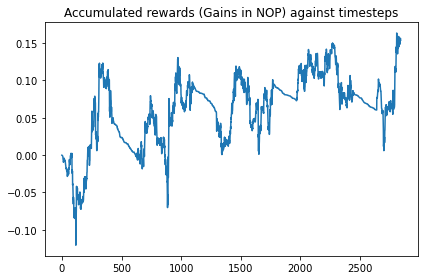

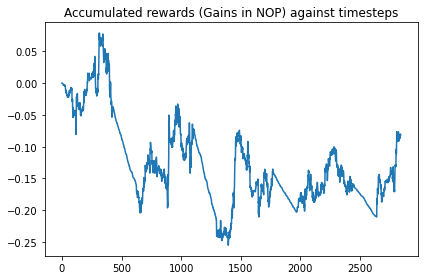

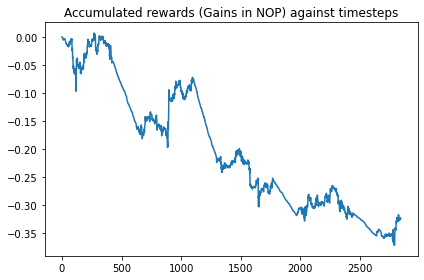

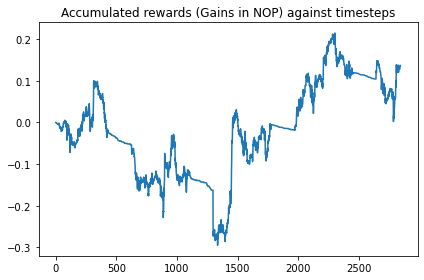

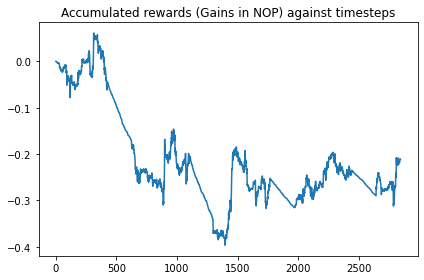

In [84]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

logger = JSONLogger(path="BO_logs.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

optimizer.maximize(init_points=2, n_iter=3)

In [ ]:
EURUSD_trade_df=data.load_ohlc_dataset("15min/EURUSD/02_17.csv")
GBPUSD_trade_df=data.load_ohlc_dataset("15min/GBPUSD/02_17.csv")
USDJPY_trade_df=data.load_ohlc_dataset("15min/USDJPY/02_17.csv")
EURUSD_trade, tech_indicator_list = preprocessors.FeatureEngineer(EURUSD_trade_df,
                          tech_indicator_params_map = param_map,
                          use_technical_indicator=True,
                          user_defined_feature=False).preprocess_data()

GBPUSD_trade, tech_indicator_list = preprocessors.FeatureEngineer(GBPUSD_trade_df,
                          tech_indicator_params_map = param_map,
                          use_technical_indicator=True,
                          user_defined_feature=False).preprocess_data()
USDJPY_trade, tech_indicator_list = preprocessors.FeatureEngineer(USDJPY_trade_df,
                          tech_indicator_params_map = param_map,
                          use_technical_indicator=True,
                          user_defined_feature=False).preprocess_data()
dfs_list = {
    "EURUSD" : EURUSD_trade,
    "GBPUSD" : GBPUSD_trade
    "USDJPY" : USDJPY_trade
}
stock_dimension = len(dfs_list)
state_space = 1 + 3*stock_dimension + len(tech_indicator_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


In [ ]:
env_kwargs = {
    "hmax": 10000, 
    "dfs_list" : dfs_list,
    "initial_amount": 100000, 
    "buy_cost_pct": 0, 
    "sell_cost_pct": 0, 
    "state_space": state_space, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
}

In [ ]:
e_trade_gym = StockTradingEnv(**env_kwargs)
env_trade, _ = e_trade_gym.get_sb_env()

In [ ]:
episodes_rewards, episode_lengths, rewards_memory_episodes = evaluate_policy_rewards(trained_a2c, env_trade, deterministic=False)

In [74]:
def plot_rewards_with_spread(rewards_memory_episodes : list):
    for i in range(rewards_memory_episodes):
        fig = plt.figure()
        gs = fig.add_gridspec(2, hspace=0)
        axs = gs.subplots(sharex=True, sharey=False)
        fig.suptitle("Rewards (Gains in NOP)(Top) &\n Bid-Ask spreads(Bottom) against timesteps")
        axs[0].plot(rewards_memory_episodes[i])
        axs[1].plot(e_trade_gym.df[('EURUSD', 'ask_close')]-e_trade_gym.df[('EURUSD','bid_close')])
        fig.savefig(f'plots/performance_{i}')

In [ ]:
perf_stats_all = BackTestStats(account_value=rewards_memory_episodes[0])